# Experimento 2: Pipeline con MLForest
En este notebook vamos a Entrenar un Pipeline en donde usaremos tres modelos LGBM, XGboost y Random Forest.

Entrenamos con datos hasta FEB19 y tratamos de predecir ABR19.

https://forecastegy.com/posts/multivariate-time-series-forecasting-in-python/

## Importamos librerías

In [55]:
###### Feature Engineering ######
import pandas as pd
import numpy as np
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

###### Forecasting ######
from empresa4.datasets import nombres_datasets, get_dataset
from empresa4.core import calculate_error

###### Models ######
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb 

###### Visualize ######
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

###### Pipelines ######
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from mlforecast import MLForecast
from utilsforecast.plotting import plot_series
from scipy.stats import linregress

In [3]:
# Set the display.max_columns to None to display all columns
pd.set_option('display.max_columns', None)

In [4]:
# Imprime la lista de nombres de datasets
for nombre in nombres_datasets:
    print(nombre)

01_original
01_producto_estrella
01_productos_todos
01_por_cliente
01_120
02_original
02_producto_estrella
02_productos_todos
02_por_cliente
02_precios_cuidados
02_120
maestro_productos
02_productos_todos_anti_leak
02_120_anti_leak
02_stocks_productos_todos
02_stocks_anti_leak


## Funciones

In [56]:
def plot_toneladas(df):
    # Convertimos el campo 'periodo' a un tipo de dato de fecha
    df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

    # Ordenamos el DataFrame por 'periodo'
    df_sorted = df.sort_values('periodo')

    # Agrupamos los datos por 'periodo' y sumamos las toneladas
    grouped_data = df_sorted.groupby('periodo')['tn'].sum().reset_index()

    # Creamos el gráfico de líneas
    plt.figure(figsize=(15, 7))
    plt.plot(grouped_data['periodo'], grouped_data['tn'], marker='o', color='blue')

    # Formateamos el eje x para mostrar las fechas correctamente
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    
    # Añadimos título y etiquetas a los ejes
    plt.title('Evolución de Toneladas a lo largo del Tiempo')
    plt.xlabel('Periodo')
    plt.ylabel('Toneladas (tn)')
    plt.xticks(rotation=90)  # Rotamos las etiquetas del eje x para mejor lectura
    plt.grid(True)  # Añadimos una grilla para mejor visualización
    plt.tight_layout()  # Ajustamos la disposición

    # Mostramos el gráfico
    plt.show()

# Función para calcular la variación porcentual dentro de cada grupo
def calculate_pct_change(group):
    # Calcula el cambio porcentual para cada producto a lo largo del tiempo
    group['cust_request_tn_pct_change'] = group['cust_request_tn'].pct_change().fillna(0) * 100
    group['tn_pct_change'] = group['tn'].pct_change().fillna(0) * 100
    
    # Trata el caso donde el valor previo es cero, lo que resultaría en un cambio porcentual infinito
    # Si el valor previo es 0 y el nuevo valor es mayor que 0, establece el cambio porcentual en un valor arbitrario (e.g., 100%)
    group['cust_request_tn_pct_change'] = group['cust_request_tn_pct_change'].replace([float('inf'), float('-inf')], 100)
    group['tn_pct_change'] = group['tn_pct_change'].replace([float('inf'), float('-inf')], 100)
    
    # Intercambiamos las TN por variaciones porcentuales
    group = group.drop(['tn'], axis=1)
    group.rename(columns={'tn_pct_change': 'tn'}, inplace=True)
    
    return group


def dame_lags_y_deltas(df,nombre_col_original,cant_lags,incluir_deltas=False):
    """
    Agregar columnas con lags y (opcionalmente) deltas
    
    Input:
    - df : (dataframe) Es donde vive la columna nombre_col_original. Ademas tiene q incluir los campos: "product_id" y "periodo"
    - nombre_col_original: (string) Es la columna de interes (ej: "tn")
    - cant_lags: (int) Entero que define la cantidad de lags q va a calcular
    - incluir_deltas: (bool) Se usa para definir si se van a calcular los deltas (True=calcula deltas)
 
    Output:
    - df: (dataframe) Tiene insertadas las nuevas columnas
 
    Ejemplo:
    df = dame_lags_y_deltas(df,nombre_col_original="tn",cant_lags=12,incluir_deltas=True)

    """
    
    # Los datos tienen q estar ordenados por "product_id" y por "periodo"
    df = df.sort_values(by=["product_id","periodo"]).reset_index(drop=True)
    
    #Calculamos los lags
    nombres_columnas_lags = []
    for i in range(1,cant_lags+1):
        nombre_nueva_columna = nombre_col_original+"_lag_"+str(i)
        nombres_columnas_lags.append(nombre_nueva_columna)
        df_aux = df.groupby(['product_id'])[nombre_col_original].shift(i).rename(nombre_nueva_columna)
        df=pd.concat([df,df_aux],axis=1)  
        
    #Si corresponde, calculamos los delta lags
    if incluir_deltas == True:
        prefijo_delta_lags = "delta_lag_" # va a tener ESTO mas un numero de 1 a N
        df_aux=pd.DataFrame()
        #Se calculan lag1-lag2, lag2-lag3, lag3-lag4, etc...
        for i in range(0,len(nombres_columnas_lags)-1):
            df_aux[prefijo_delta_lags+str(i+1)] = df[nombres_columnas_lags[i]]-df[nombres_columnas_lags[i+1]]
        #Lo unificamos con el df original
        df = pd.concat([df,df_aux],axis=1)  
        
    return df

def dame_medias_moviles(df,nombre_col_original,lista_medias_target,incluye_periodo_actual=False):
    
    """
    Calculamos las medias de los ultimos N meses.
    Cada entero "k" que agregues al vector de aca abajo va a crear una columna nueva con 
    el promedio de esos "k" meses previos 
    Podes controlar si incluye o no al periodo actual mediante la variable incluye_periodo_actual
    
    Input: 
    - df : (dataframe) Es donde vive la columna nombre_col_original. Ademas tiene q incluir los campos: "product_id" y "periodo"
    - nombre_col_original: (string) Es la columna de interes (ej: "tn")
    - lista_medias_target: (list) Lista de enteros para saber el tamanio de las ventanas para las medias moviles
    - incluye_periodo_actual: (bool) Es para definir si se debe tener en cuenta o no el periodo actual para el calculo de la media movil (por defecto es False, asi que NO se usa el periodo actual)
    
    Output:
    - df: (dataframe) Tiene insertadas las nuevas columnas
    
    Ejemplo:
    df = dame_medias_moviles(df,nombre_col_original="tn",lista_medias_target=[1,3,6,12],incluye_periodo_actual=False)
    
    """
    
    # Los datos tienen q estar ordenados por "product_id" y por "periodo"
    df = df.sort_values(by=["product_id","periodo"]).reset_index(drop=True)
    
    prefijo = nombre_col_original + "_media_movil_"
    
    if incluye_periodo_actual==True:
        SHIFT=0
    else:
        SHIFT=1

    for i in lista_medias_target:
        df_aux = df.groupby('product_id').rolling(window=i,min_periods=i)[nombre_col_original].mean().shift(SHIFT).rename(prefijo+str(i)).reset_index(drop=True)
        df = pd.concat([df,df_aux],axis=1)
        
    return df

def dame_tendencias(df,nombre_col_original,lista_tamanio_ventana_tendencias,incluye_periodo_actual=False):
    """
    Calcula la pendiente de la recta q aproxima a los elementos dentro de una ventana movil de periodos.
   
   Input:
    - df : (dataframe) Es donde vive la columna nombre_col_original. Ademas tiene q incluir los campos: "product_id" y "periodo"
    - nombre_col_original: (string) Es la columna de interes (ej: "tn")
    - lista_tamanio_ventana_tendencias: (list) Lista de enteros para indicar cant de periodos, en meses, que debe medir de largo la ventana
    - incluye_periodo_actual: (bool) Es para definir si la ventana debe incluir o no al periodo actual. Por defecto vale False (asi q NO lo incluye)

    Output:
    - df: (dataframe) Tiene insertadas las nuevas columnas
    
    Ejemplo:
    df = dame_tendencias(df,nombre_col_original="tn", lista_tamanio_ventana_tendencias=[3,6,12],incluye_periodo_actual=False)
    """
    
    prefijo = nombre_col_original + "_tendencia_"

    # Los datos tienen q estar ordenados por "product_id" y por "periodo"
    df = df.sort_values(by=["product_id","periodo"]).reset_index(drop=True)
    
    if incluye_periodo_actual==True:
        SHIFT=0
    else:
        SHIFT=1

    for i in lista_tamanio_ventana_tendencias:
        df_aux = df.groupby('product_id')[nombre_col_original].rolling(window=i, min_periods=i).apply(lambda v: linregress(np.arange(len(v)), v).slope).shift(SHIFT).rename(prefijo+str(i)).reset_index(level=0, drop=True)
        df = pd.concat([df,df_aux],axis=1)
        
    return df

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Inicialización de los encoders para cada columna
        self.encoders = None

    def fit(self, X, y=None):
        self.encoders = {}
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = self.encoders[col].transform(X[col])
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

## Importamos Datasets

In [6]:
df_tb_sellout = get_dataset("02_productos_todos")
maestro_productos = get_dataset("maestro_productos")
precios_cuidados = get_dataset("02_precios_cuidados")

## Pre Processing

In [7]:
df_tb_sellout = df_tb_sellout.drop(['cat2'], axis = 1)
# Juntamos los datasets Sellout con el maestro de productos
df_sellout_with_cat = pd.merge(df_tb_sellout, maestro_productos[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size']], on=['product_id'], how='left')
# Agrupamos por categorías de productos
df_aggregated = df_sellout_with_cat.groupby(['periodo', 'product_id', 'plan_precios_cuidados', 'cat1', 'cat2', 'cat3', 'brand']).agg({'cust_request_tn': 'sum','tn': 'sum'}).reset_index()

## Análisis Exploratorio

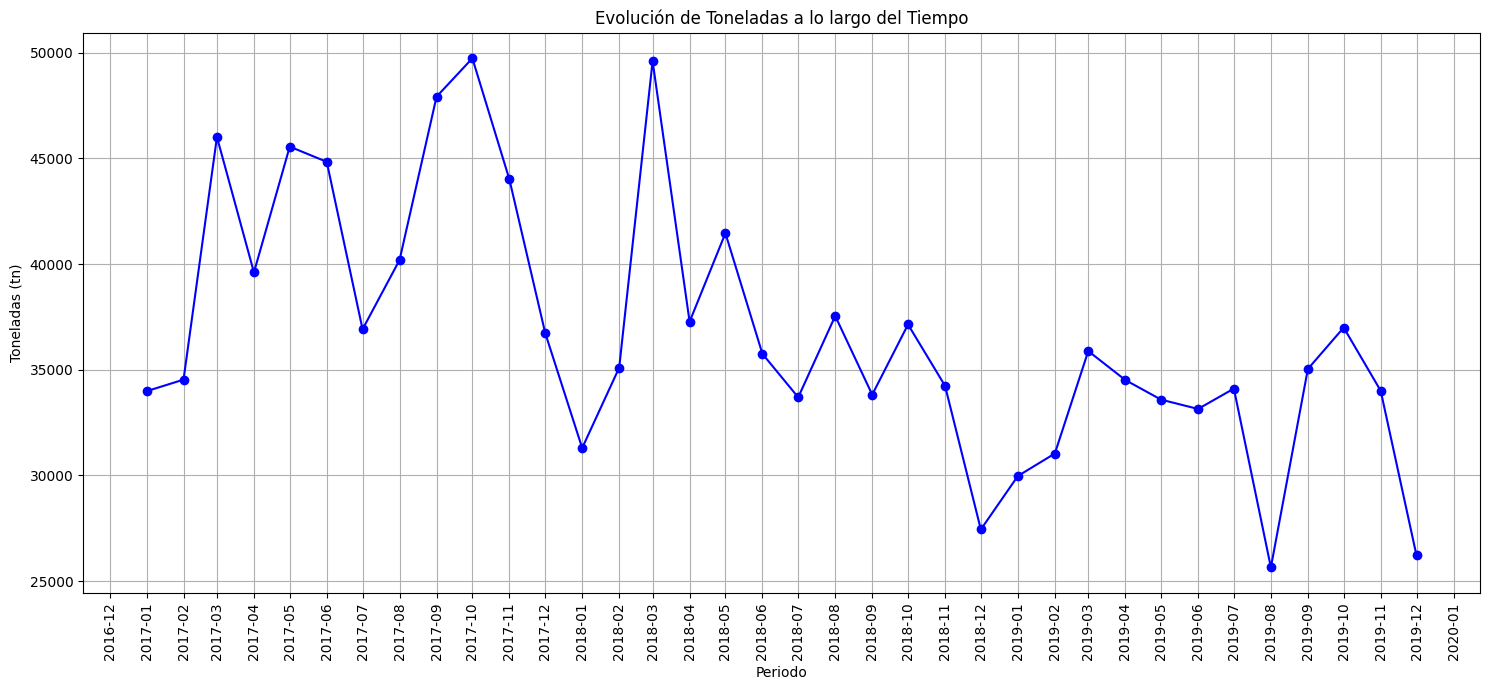

In [8]:
plot_toneladas(df_aggregated)

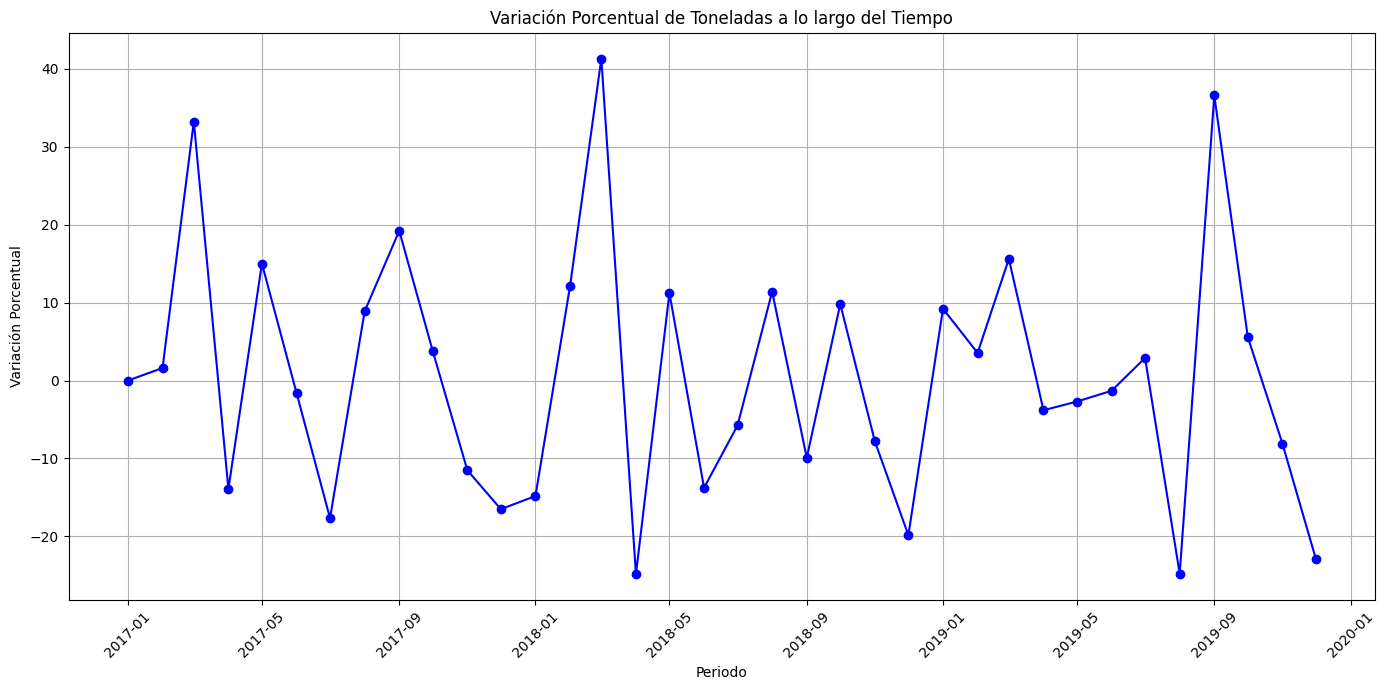

In [13]:
tn_totales = df_aggregated.groupby('periodo')['tn'].sum()

# Transformando la Serie en DataFrame con reset_index para hacer las columnas 'periodo' y 'tn'
tn_totales = tn_totales.reset_index()

tn_totales['periodo'] = pd.to_datetime(tn_totales['periodo'])
# Calculamos la variación porcentual
tn_totales = tn_totales.set_index('periodo')
tn_pct_change = tn_totales.pct_change().fillna(0) * 100

# Graficamos la variación porcentual
plt.figure(figsize=(14, 7))
plt.plot(tn_pct_change.index, tn_pct_change['tn'], marker='o', linestyle='-', color='blue')
plt.title('Variación Porcentual de Toneladas a lo largo del Tiempo')
plt.xlabel('Periodo')
plt.ylabel('Variación Porcentual')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama
plt.show()


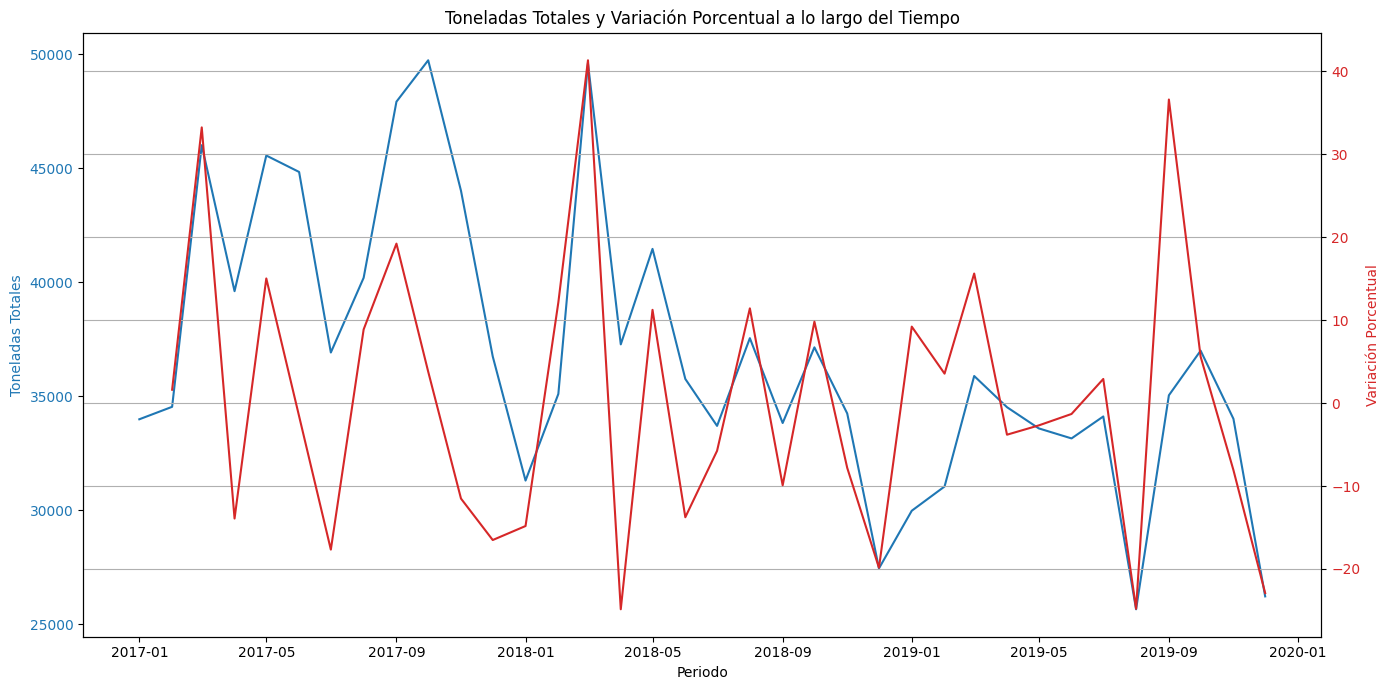

In [14]:
tn_totales = df_aggregated.groupby('periodo')['tn'].sum()

# Transformando la Serie en DataFrame con reset_index para hacer las columnas 'periodo' y 'tn'
tn_totales = tn_totales.reset_index()

tn_totales['periodo'] = pd.to_datetime(tn_totales['periodo'])
tn_totales['tn_pct_change'] = tn_totales['tn'].pct_change() * 100

# Ahora, vamos a graficar ambas, las toneladas totales y las variaciones porcentuales
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje izquierdo para las toneladas totales
ax1.set_xlabel('Periodo')
ax1.set_ylabel('Toneladas Totales', color='tab:blue')
ax1.plot(tn_totales['periodo'], tn_totales['tn'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creamos un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()
ax2.set_ylabel('Variación Porcentual', color='tab:red')
ax2.plot(tn_totales['periodo'], tn_totales['tn_pct_change'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Título y grid
plt.title('Toneladas Totales y Variación Porcentual a lo largo del Tiempo')
fig.tight_layout()
plt.grid(True)
plt.show()


## Feature Engineering

### Proyectando toneladas

In [8]:
# Generamos los lags
df_complete_lags = dame_lags_y_deltas(df_aggregated,nombre_col_original = "tn" ,cant_lags = 12,incluir_deltas=True)
# Generamos los DELTA lags
df_complete_lags_mm = dame_medias_moviles(df_complete_lags,
                               nombre_col_original = "tn",
                               lista_medias_target = [2,3,4,6,10], # cant periodos, en meses, que debe medir de largo la ventana
                               incluye_periodo_actual= False) # definir si la ventana debe incluir o no al periodo actual
df_complete_lags_mm = df_complete_lags_mm.fillna(0)

# Generamos tendencias
df_final = dame_tendencias(df_complete_lags_mm,
                                            nombre_col_original = "tn",
                                            lista_tamanio_ventana_tendencias = [3,6,12], # cant de periodos, en meses, que debe medir de largo la ventana
                                            incluye_periodo_actual = False)
df_final = df_final.fillna(0)

### Proyectando Variaciones porcentuales de las TN

In [9]:
# Convertimos las Toneladas en variaciones porcentuales
df_aggregated_var = df_aggregated.copy()
# Asegúrate de que los datos estén ordenados por producto y luego por período
df_aggregated_var.sort_values(by=['product_id', 'periodo'], inplace=True)

# Aplica la función a cada grupo de product_id
df_aggregated_var = df_aggregated_var.groupby(['product_id']).apply(calculate_pct_change)

# Opcional: resetea el índice si se desordenó durante el agrupamiento
df_aggregated_var.reset_index(drop=True, inplace=True)

In [10]:
# Generamos los lags
df_complete_lags = dame_lags_y_deltas(df_aggregated_var,nombre_col_original = "tn" ,cant_lags = 12,incluir_deltas=True)
# Generamos los DELTA lags
df_complete_lags_mm = dame_medias_moviles(df_complete_lags,
                               nombre_col_original = "tn",
                               lista_medias_target = [2,3,4,6,10], # cant periodos, en meses, que debe medir de largo la ventana
                               incluye_periodo_actual= False) # definir si la ventana debe incluir o no al periodo actual
df_complete_lags_mm = df_complete_lags_mm.fillna(0)

# Generamos tendencias
df_final_var = dame_tendencias(df_complete_lags_mm,
                                            nombre_col_original = "tn",
                                            lista_tamanio_ventana_tendencias = [3,6,12], # cant de periodos, en meses, que debe medir de largo la ventana
                                            incluye_periodo_actual = False)
df_final_var = df_final_var.fillna(0)

## Cross Validation por corte temporal

### Proyectando toneladas

In [18]:
# Assuming df_final is the DataFrame you want to split into train and validation sets:
df_final['periodo'] = pd.to_datetime(df_final['periodo'], format='%Y%m')

# Cortamos hasta Febrero inclusive como TRAIN
train = df_final[df_final['periodo'] <= pd.to_datetime('201902', format='%Y%m')]
# Usamos MARZO como test
valid = df_final[df_final['periodo'] == pd.to_datetime('201904', format='%Y%m')]

### Proyectando variaciones porcentuales

In [19]:
# Assuming df_final is the DataFrame you want to split into train and validation sets:
df_final_var['periodo'] = pd.to_datetime(df_final_var['periodo'], format='%Y%m')

# Cortamos hasta Febrero inclusive como TRAIN
train_var = df_final_var[df_final_var['periodo'] <= pd.to_datetime('201902', format='%Y%m')]
# Usamos Abril como test
valid_set_var = df_final_var[df_final_var['periodo'] == pd.to_datetime('201904', format='%Y%m')]

In [20]:
# Reemplazar infinitos con NaN
train_var.replace([np.inf, -np.inf], np.nan, inplace=True)

# Verificar y manejar valores demasiado grandes para float32
float32_max = np.finfo(np.float32).max
float32_min = np.finfo(np.float32).min

train_var[train_var.select_dtypes(include=[np.number]).columns] = \
    train_var.select_dtypes(include=[np.number]).applymap(lambda x: np.nan if x > float32_max or x < float32_min else x)


C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\2247313666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_var.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\2247313666.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_var.select_dtypes(include=[np.number]).applymap(lambda x: np.nan if x > float32_max or x < float32_min else x)
C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\2247313666.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_var[train_var

In [21]:
# Por ejemplo, reemplazando NaN con la mediana de la columna
for col in train_var.columns:
    if train_var[col].dtype in [np.float64, np.float32]:
        train_var[col].fillna(train_var[col].median(), inplace=True)

C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\3606509377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_var[col].fillna(train_var[col].median(), inplace=True)
C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\3606509377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_var[col].fillna(train_var[col].median(), inplace=True)
C:\Users\Lean\AppData\Local\Temp\ipykernel_16200\3606509377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

## Modeling

### Pipeline multiples algoritmos (código de Gustavo)

#### Proyectando toneladas

In [57]:
# List of dynamic features used during training
dynamic_features = ['plan_precios_cuidados','cust_request_tn', 'tn_lag_1', 'tn_lag_2',
                     'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8',
                     'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'delta_lag_1',
                     'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5',
                     'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9',
                     'delta_lag_10', 'delta_lag_11', 'tn_media_movil_2', 'tn_media_movil_3',
                     'tn_media_movil_4', 'tn_media_movil_6', 'tn_media_movil_10',
                     'tn_tendencia_3', 'tn_tendencia_6', 'tn_tendencia_12']

# Prepare the DataFrame with the required features for prediction
dynamic_df_for_prediction = valid[['product_id', 'periodo'] + dynamic_features]

In [58]:
# Specify the categorical columns you want to encode
categorical_columns = ['cat1', 'cat2', 'cat3', 'brand']

# Create a ColumnTransformer with the custom transformer for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', MultiColumnLabelEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # This leaves the rest of the columns untouched
)

# Now include LGBMRegressor in your list of models
models = [
    Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('lightgbm', lgb.LGBMRegressor(random_state=0, n_estimators=100))  # Add LGBMRegressor
    ])
]

# Assuming MLForecast is a class that has been defined to take these models
model = MLForecast(models=models,
                   freq='M',
                   lags=[1,2,3,4,5,6,7,8,9,10,11,12],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                   },
                   date_features=['month'],
                   num_threads=6)


In [330]:
# Step 1: Train the model
model.fit(train, id_col='product_id', time_col='periodo', target_col='tn')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12154
[LightGBM] [Info] Number of data points in the train set: 17514, number of used features: 53
[LightGBM] [Info] Start training from score 28.286166


MLForecast(models=[Pipeline, Pipeline2, Pipeline3], freq=<MonthEnd>, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'rolling_mean_lag1_window_size4', 'rolling_min_lag1_window_size4', 'rolling_max_lag1_window_size4'], date_features=['month'], num_threads=6)

In [331]:
# Step 2: Predict one period ahead
predictions = model.predict(horizon=3, dynamic_dfs=[dynamic_df_for_prediction])
predictions.rename(columns={'Pipeline': 'random_forest', 
                            'Pipeline2': 'xgboost', 
                            'Pipeline3': 'lightgbm'}, inplace=True)

In [332]:
# Hacer una copia para evitar SettingWithCopyWarning
valid_set = valid[['product_id', 'periodo', 'tn']].copy()

# Convertir la columna 'periodo' al formato deseado
valid_set['periodo'] = pd.to_datetime(valid_set['periodo']).dt.strftime('%Y%m')

# Solo necesitas hacer esto si 'predictions' no está ya en el formato AAAAMM
predictions['periodo'] = pd.to_datetime(predictions['periodo']).dt.strftime('%Y%m')

# Fusionar predicciones con el conjunto de validación para comparar los valores reales con los pronósticos
p = predictions.merge(valid_set, on=['product_id', 'periodo'], how='left', suffixes=('', '_actual'))

p = p[p.periodo == '201904']

In [333]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Here 'p' is your DataFrame containing the actual values and predictions
print(f"SMAPE Random Forest Pipeline: {smape(p['tn'], p['random_forest'])}")
print(f"SMAPE XGBRegressor: {smape(p['tn'], p['xgboost'])}")
print(f"SMAPE LGBMRegressor: {smape(p['tn'], p['lightgbm'])}")


SMAPE Random Forest Pipeline: 29.220851955117595
SMAPE XGBRegressor: 46.21335490942056
SMAPE LGBMRegressor: 45.85480352179064


In [334]:
calculate_error(p.lightgbm.to_numpy(), p.tn.to_numpy())

print(f"Error Rate Random Forest Pipeline: {calculate_error(p.random_forest.to_numpy(), p.tn.to_numpy())}")
print(f"Error Rate XGBRegressor: {calculate_error(p.xgboost.to_numpy(),p.tn.to_numpy())}")
print(f"Error Rate LGBMRegressor: {calculate_error(p.lightgbm.to_numpy(), p.tn.to_numpy())}")

Error Rate Random Forest Pipeline: 0.29989874270559
Error Rate XGBRegressor: 0.30014141871692535
Error Rate LGBMRegressor: 0.29486514314990714


In [214]:
df_final.rename(columns={'product_id':'unique_id','periodo':'ds', 'tn':'y'}, inplace=True)
predictions.rename(columns={'product_id':'unique_id','periodo':'ds', 'tn':'y'}, inplace=True)
predictions['ds'] = pd.to_datetime(predictions['ds'], format='%Y%m')

In [216]:
fig = plot_series(df_final, predictions, max_ids=4, plot_random=False)
fig.savefig('example.png', bbox_inches='tight')

#### Proyectando Variaciones porcentuales

In [43]:
# List of dynamic features used during training
dynamic_features = ['plan_precios_cuidados','cust_request_tn', 'tn_lag_1', 'tn_lag_2',
                     'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8',
                     'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'delta_lag_1',
                     'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5',
                     'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9',
                     'delta_lag_10', 'delta_lag_11', 'tn_media_movil_2', 'tn_media_movil_3',
                     'tn_media_movil_4', 'tn_media_movil_6', 'tn_media_movil_10',
                     'tn_tendencia_3', 'tn_tendencia_6', 'tn_tendencia_12']

# Prepare the DataFrame with the required features for prediction
dynamic_df_for_prediction = valid_set_var[['product_id', 'periodo'] + dynamic_features]
# Specify the categorical columns you want to encode
categorical_columns = ['cat1', 'cat2', 'cat3', 'brand']

In [44]:
# Create a ColumnTransformer with the custom transformer for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', MultiColumnLabelEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # This leaves the rest of the columns untouched
)

# Now include LGBMRegressor in your list of models
models = [
    Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('lightgbm', lgb.LGBMRegressor(random_state=0, n_estimators=100))  # Add LGBMRegressor
    ])
]

# Assuming MLForecast is a class that has been defined to take these models
model = MLForecast(models=models,
                   freq='M',
                   lags=[1,2,3,4,5,6,7,8,9,10,11,12],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                   },
                   date_features=['month'],
                   num_threads=6)

In [45]:
# Step 1: Train the model
model.fit(train_var, id_col='product_id', time_col='periodo', target_col='tn')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12409
[LightGBM] [Info] Number of data points in the train set: 17514, number of used features: 54
[LightGBM] [Info] Start training from score 62.997524


MLForecast(models=[Pipeline, Pipeline2, Pipeline3], freq=<MonthEnd>, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'rolling_mean_lag1_window_size4', 'rolling_min_lag1_window_size4', 'rolling_max_lag1_window_size4'], date_features=['month'], num_threads=6)

In [46]:
# Step 2: Predict one period ahead
predictions = model.predict(horizon=3, dynamic_dfs=[dynamic_df_for_prediction])
predictions.rename(columns={'Pipeline': 'random_forest', 
                            'Pipeline2': 'xgboost', 
                            'Pipeline3': 'lightgbm'}, inplace=True)

In [47]:
# Hacer una copia para evitar SettingWithCopyWarning
valid_set_var = valid_set_var[['product_id', 'periodo', 'tn']].copy()

# Convertir la columna 'periodo' al formato deseado
valid_set_var['periodo'] = pd.to_datetime(valid_set_var['periodo']).dt.strftime('%Y%m')

# Solo necesitas hacer esto si 'predictions' no está ya en el formato AAAAMM
predictions['periodo'] = pd.to_datetime(predictions['periodo']).dt.strftime('%Y%m')

In [48]:
# Fusionar predicciones con el conjunto de validación para comparar los valores reales con los pronósticos
p = predictions.merge(valid_set_var, on=['product_id', 'periodo'], how='left', suffixes=('', '_actual'))

p = p[p.periodo == '201904']
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Here 'p' is your DataFrame containing the actual values and predictions
print(f"SMAPE Random Forest Pipeline: {smape(p['tn'], p['random_forest'])}")
print(f"SMAPE XGBRegressor: {smape(p['tn'], p['xgboost'])}")
print(f"SMAPE LGBMRegressor: {smape(p['tn'], p['lightgbm'])}")

SMAPE Random Forest Pipeline: 77.62121302315619
SMAPE XGBRegressor: 83.0479726409689
SMAPE LGBMRegressor: 83.0169702591834


In [49]:
p

,product_id,periodo,random_forest,xgboost,lightgbm,tn
2,20001,201904,-5.639542,-0.271215,-1.231762,12.034214
5,20002,201904,-19.692823,-19.240442,-20.768306,18.825502
8,20003,201904,-21.117503,-22.119207,-22.052965,-11.394638
11,20004,201904,-14.888338,-14.779128,-15.644425,-24.696520
14,20005,201904,10.896271,9.409397,9.232010,28.017420
...,...,...,...,...,...,...
3740,21276,201904,0.000000,0.040465,-0.001788,-16.948322
3743,21280,201904,0.000000,-0.001891,-0.001788,0.000000
3746,21282,201904,0.000000,0.040465,-0.001788,0.000000
3749,21287,201904,0.000000,-0.004777,-0.001788,0.000000


In [50]:
def error_rate(actual, forecast):
    # Evita la división por cero agregando un número pequeño al denominador
   
    return np.mean(np.abs((actual - forecast) / (actual + 0.0000000001))) * 100

# Calcula el error rate para cada modelo
error_rate_rf = error_rate(p['tn'], p['random_forest'])
error_rate_xgb = error_rate(p['tn'], p['xgboost'])
error_rate_lgbm = error_rate(p['tn'], p['lightgbm'])

# Imprime los resultados
print(f"Error Rate Random Forest: {error_rate_rf}")
print(f"Error Rate XGBRegressor: {error_rate_xgb}")
print(f"Error Rate LGBMRegressor: {error_rate_lgbm}")


Error Rate Random Forest: 5436720956532.433
Error Rate XGBRegressor: 5340843770270.771
Error Rate LGBMRegressor: 23492269611275.312


In [51]:
print(f"Error Rate Random Forest Pipeline: {calculate_error(p.random_forest.to_numpy(), p.tn.to_numpy())}")
print(f"Error Rate XGBRegressor: {calculate_error(p.xgboost.to_numpy(),p.tn.to_numpy())}")
print(f"Error Rate LGBMRegressor: {calculate_error(p.lightgbm.to_numpy(), p.tn.to_numpy())}")

Error Rate Random Forest Pipeline: 3.047070877345055
Error Rate XGBRegressor: 3.033893141449266
Error Rate LGBMRegressor: 3.6735806310472556


In [53]:
df_final_var.rename(columns={'product_id':'unique_id','periodo':'ds', 'tn':'y'}, inplace=True)
predictions.rename(columns={'product_id':'unique_id','periodo':'ds', 'tn':'y'}, inplace=True)
predictions['ds'] = pd.to_datetime(predictions['ds'], format='%Y%m')

In [54]:
fig = plot_series(df_final_var, predictions, max_ids=4, plot_random=False)
fig.savefig('example.png', bbox_inches='tight')